In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import pickle
import io
from sparse_causal_model_learner_rl.trainable.gumbel_switch import WithInputSwitch, sample_from_logits_simple
gin.enter_interactive_mode()
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices

In [2]:
ckpt = '/home/sergei/ray_results/5x5_1f1c1k_obs_rec_nonlin_gnn_gumbel_siamese_l2_kc_dec_stop_after_completes/main_fcn_d66d7_00000_0_2021-02-01_22-09-57/checkpoint_0/checkpoint'

In [3]:
class LinearModel(nn.Module):
    def __init__(self, input_shape):
        super(LinearModel, self).__init__()
        self.layer = nn.Linear(in_features=10, out_features=1, bias=True)
    def forward(self, x):
        return self.layer(x)

In [4]:
import ray
ray.init(address='10.90.38.7:6379', ignore_reinit_error=True)

2021-02-02 12:48:56,263	INFO worker.py:651 -- Connecting to existing Ray cluster at address: 10.90.38.7:6379


{'node_ip_address': '10.90.38.7',
 'raylet_ip_address': '10.90.38.7',
 'redis_address': '10.90.38.7:6379',
 'object_store_address': '/tmp/ray/session_2021-01-29_10-33-31_725376_19160/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-29_10-33-31_725376_19160/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2021-01-29_10-33-31_725376_19160',
 'metrics_export_port': 44143,
 'node_id': 'f237fb11fb3bc81e67f20ea7d86350e858dd333a'}

In [5]:
# https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [6]:
with open(ckpt, 'rb') as f:
    learner = pickle.load(f)#CPU_Unpickler(f).load()#pickle.load(f)

2021-02-02 12:48:58,766	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name a2d12432-654c-11eb-af1d-90e2baa1a248
Make environment KeyChest-v0 None {}


In [7]:
learner.collect_steps()

In [8]:
ctx = learner._context

In [9]:
ox = ctx['obs_x']
oy = ctx['obs_y']
ax = ctx['action_x']
obs = ctx['obs']

In [10]:
obs_ns = None
obs_s = None

In [11]:
def siamese_feature_discriminator_l2(obs, decoder, margin=1.0, **kwargs):
    def loss(y_true, y_pred):
        """L2 norm for the distance, no flat."""
        delta = y_true - y_pred
        delta = delta.pow(2)
        delta = delta.flatten(start_dim=1)
        delta = delta.sum(1)
        return delta

    # original inputs order
    batch_dim = obs.shape[0]

    # random permutation for incorrect inputs
    idxes = torch.randperm(batch_dim).to(obs.device)
    obs_shuffled = obs[idxes]

    idxes_orig = torch.arange(start=0, end=batch_dim).to(obs.device)
    target_incorrect = (idxes == idxes_orig).to(obs.device)
    
    delta_obs_obs_shuffled = (obs - obs_shuffled).pow(2).flatten(start_dim=1).max(1).values

    # distance_shuffle = loss(obs, obs_shuffled)
    distance_f = loss(decoder(obs), decoder(obs_shuffled))
    
    global obs_ns, obs_s
    obs_ns = obs
    obs_s = obs_shuffled

    # print(torch.nn.ReLU()(margin - distance_f), torch.where)

    return {'loss': torch.where(~target_incorrect, torch.nn.ReLU()(margin - distance_f), distance_f).mean(),
            'metrics': {'distance_plus': distance_f[~target_incorrect].mean().item(),
                        'distance_minus': distance_f[target_incorrect].mean().item(),
                        'delta_obs_obs_shuffled': delta_obs_obs_shuffled.detach().cpu().numpy(),
                        'same_input_frac': (1.*target_incorrect).mean().item()}
            }

In [12]:
siamese_feature_discriminator_l2(**ctx)

{'loss': tensor(0.5387, device='cuda:0', grad_fn=<MeanBackward0>),
 'metrics': {'distance_plus': 0.5496174097061157,
  'distance_minus': nan,
  'delta_obs_obs_shuffled': array([3.9920118, 3.9920118, 3.9920118, ..., 3.9920118, 3.9920118,
         3.9920118], dtype=float32),
  'same_input_frac': 0.0}}

In [13]:
#plt.hist(np.log(siamese_feature_discriminator_l2(**ctx)['metrics']['delta_obs_obs_shuffled']))

In [14]:
delta = obs_s - obs_ns

In [15]:
from collections import Counter

In [16]:
#learner.collect_steps()

In [17]:
learner.env.engine

(array([   0.,    0.,    0.,    0.,    0., 5003.,    0.,    0.,    0.,
           0.]),
 array([1.4980019, 1.598002 , 1.698002 , 1.7980019, 1.8980019, 1.9980019,
        2.098002 , 2.1980019, 2.298002 , 2.398002 , 2.498002 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

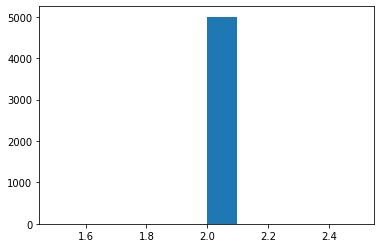

In [18]:
plt.hist(delta.abs().flatten(start_dim=1).max(1).values.cpu().numpy())

In [19]:
opt = torch.optim.Adam(params=learner.decoder.parameters(), lr=1e-3)

In [20]:
from causal_util.collect_data import EnvDataCollector

In [26]:
learner.env = learner.create_env()
learner.collector = EnvDataCollector(learner.env)

Make environment KeyChest-v0 None {}


In [22]:
learner.env.engine

In [23]:
losses = []
dplus = []

In [28]:
for _ in tqdm(range(1000)):
    learner.collect_steps()
    ctx = learner._context
    
    for _ in range(5):
        opt.zero_grad()

        l = siamese_feature_discriminator_l2(**ctx, margin=1.0)
        loss = l['loss']
        loss.backward()

        losses.append(loss.item())
        dplus.append(l['metrics']['distance_plus'])

        opt.step()

KeyboardInterrupt: 

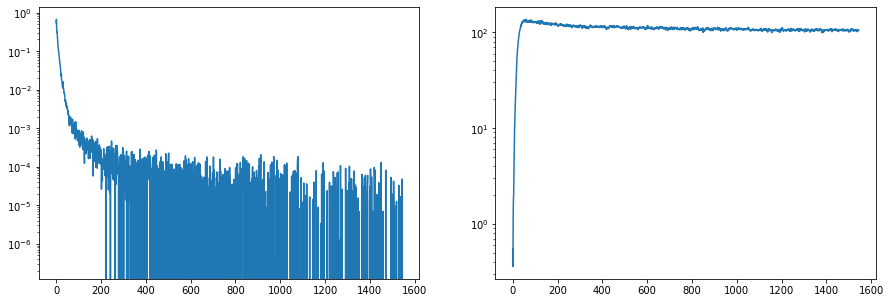

In [29]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.yscale('log')
plt.subplot(1, 2, 2)
plt.yscale('log')
plt.plot(dplus)